In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers

from sklearn.model_selection import train_test_split

from lib_classifNN import *
from lib_visu_classif import *

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import os

import pandas as pd
## In this file, we create a neural network with one hidden layer and apply it to the mnist dataset in order to address the classification problem.


In [2]:
path = 'data/FiveCitiePMData'
data = []
for f in os.listdir(path):
    print(f)
    data.append(pd.read_csv(path + '/'+ f))

GuangzhouPM20100101_20151231.csv
ShanghaiPM20100101_20151231.csv
BeijingPM20100101_20151231.csv
ShenyangPM20100101_20151231.csv
ChengduPM20100101_20151231.csv


## Cleaning the dataset 

We will try to make a regression on the PM_US Post values with some continuous and categorical variables in the dataset

In [3]:
beijing = data[2]
print(list(beijing))
np.sum(pd.isna(beijing['PM_Nongzhanguan']))
# removing the 
missing_uspost = [not(e) for e in list(pd.isna(beijing['PM_US Post'], ))]
beijing_cl = beijing[missing_uspost]

features = ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP','Iws', 'precipitation', 'Iprec']

['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']


In [4]:
# check for nas
for e in features:
    print(e, ':', np.sum(pd.isna(beijing_cl[e])), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 5 nas
HUMI : 339 nas
PRES : 339 nas
TEMP : 5 nas
Iws : 5 nas
precipitation : 473 nas
Iprec : 473 nas


In [6]:
# removing the rows for which there are NA
beijing_cl2 = beijing_cl[features + ['PM_US Post' ]].dropna(how = 'any')
X_df = beijing_cl2[features]
y_df = beijing_cl2['PM_US Post']

In [7]:
# checking another time for nas
for e in features:
    print(e, ':', np.sum(pd.isna(X_df[e])), "nas")

print('PM_US Post :', np.sum(pd.isna(y_df)), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 0 nas
HUMI : 0 nas
PRES : 0 nas
TEMP : 0 nas
Iws : 0 nas
precipitation : 0 nas
Iprec : 0 nas
PM_US Post : 0 nas


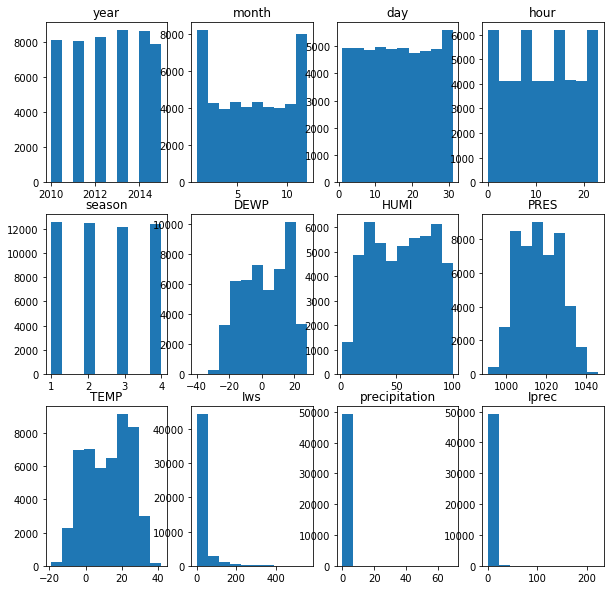

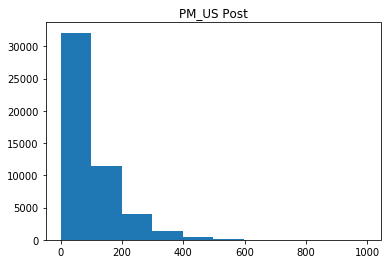

In [11]:
plt.figure(figsize= (10,10))

for i,e in enumerate(list(X_df)):
    plt.subplot(3,4,i+1)
    plt.hist(X_df[e], )
    plt.title(e)
plt.show()

plt.hist(y_df)
plt.title("PM_US Post")
plt.show()

In [17]:
# converting to numpy arrays
X = X_df.values
y = y_df.values

In [20]:
nb_samples = 1e4
indices = np.random.shuffle(np.arange(nb_samples))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('X train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (39663, 12)
y train shape:  (39663,)
X test shape:  (9916, 12)
y test shape:  (9916,)


In [2]:
# loading mnist and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# network parameters
batch_size = 128
num_classes = 10
epochs = 20

# dimensions for the NN:
# input dimension
Q = x_train.shape[1]
# hidden layer dimension
K = 100
# output dimension : classification
D = num_classes

# dropout rate
DROP_OUT = 0.5
N = x_train.shape[0]
# l2 regularization
#prior length scale
l = 1e-2
# precision parameter, un peu au pif pour l'instant
tau = 1e-1

lambd = DROP_OUT*l**2/(2*N)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(60000, 28, 28) (60000,) (10000, 28, 28)
60000 train samples
10000 test samples


## Create a sequential model with Keras 

In [3]:
model = Sequential()
model.add(Dense(K, input_shape = (Q, ), activation = 'relu', use_bias= True, kernel_regularizer = regularizers.l2(lambd),
               bias_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
# softmax layer
model.add(Dense(num_classes, use_bias = False, activation = None, kernel_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
model.add(Activation('softmax'))

In [4]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 79,500
Trainable params: 79,500
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Training the network
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

In [6]:
# Evaluation of the network
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.126255772057
Test accuracy: 0.9679


## Obtaining model uncertainty

## Vizualise data points

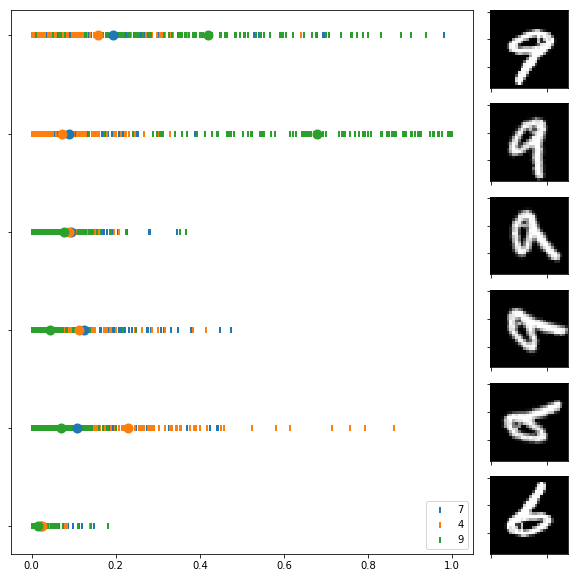

In [18]:
# change that parameter to see more classes on the plot
nb_show = 3
# index for the image sample
ix = 9
x_ex = x_test[ix]
#plot_pred_img(x_ex, model, nb_class=10)
#plt.show()
plot_rotated(x_ex, model , nb_class=10, nb_show=3)
plt.show()

## Plot one example with its classification values

Network prediction: [[  8.81622886e-10   3.84498900e-12   3.33511374e-09   5.79132964e-09
    2.48310812e-08   9.85176206e-01   1.48189655e-02   3.66877405e-12
    4.39334417e-06   4.49413534e-07]]
Networ label: 5
dropout prediction: [ 0.01251055  0.00988531  0.02347066  0.01484859  0.04795705  0.56911766
  0.2309404   0.00845579  0.04789826  0.03491573]
dropout label: 5
real label: 5


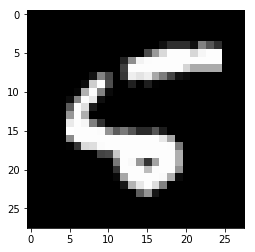

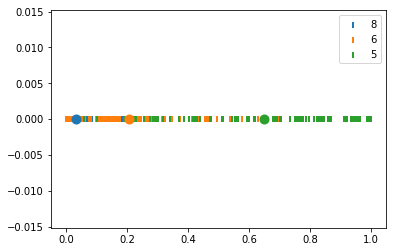

In [17]:
# change the drop_out rate to be more or less close to the classic network prediction
DROP_OUT = 0.5

ix = 8
x_ex = x_test[ix]
print("Network prediction: " + str(model.predict(x_ex.reshape((1, -1)))))
print("Networ label: "+ str(np.argmax(model.predict(x_ex.reshape((1, -1))))))

print("dropout prediction: "+ str(dropout_pred(x_ex, model, nb_cl=10, drop_out=DROP_OUT)))
print("dropout label: "+ str(dropout_pred(x_ex, model, nb_cl=10, label=True, drop_out = DROP_OUT)))

print("real label: " + str(np.argmax(y_test[ix])))

x_pl = x_ex.reshape((28,28))
plt.imshow(x_pl, cmap = "gray")
plt.show()

classes = np.argsort(model.predict(x_ex.reshape(1,-1))[0])[-3:]
S_in, S_out = softmax_in_out(x_ex, model, nb_cl=10, drop_out= DROP_OUT)
plot_pred(S_out, classes, legend=True)
plt.show()